## all(treshold_scaler, finetuning_step, seq_len) should be optimized
optimized to maximize specificity and sensitivity as well, with sensitivity considered superior (as we prefer to raise alert needlessly than omit life-danger condition)

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from NN_data_prep import set_seed, preprocess_series, prepare_dataset
from NN_models import LSTMForecaster, LSTMAttentionForecaster
from NN_model_usage import train_model, model_predict, detect_anomalies, plot_results, create_saving_path

In [2]:
param = 'puls'

df_aug = pd.read_csv('data/df_augmented_' + param + '.csv', parse_dates=['date'], date_format='%Y-%m-%d %H:%M:%S')
df_aug.set_index('date', inplace=True)
series_aug = df_aug['aug_series_00001']

df_original = pd.read_csv('data/df_stl_interpolated.csv', parse_dates=['date'], date_format='%Y-%m-%d %H:%M:%S')
df_original.set_index('date', inplace=True)
series_original = df_original[param]

In [3]:
print(series_aug.head(2))
print(series_original.head(2))

date
2023-11-13 14:00:00    112
2023-11-13 15:00:00    129
Name: aug_series_00001, dtype: int64
date
2023-11-13 14:00:00    125
2023-11-13 15:00:00    130
Name: puls, dtype: int64


In [4]:
series_dict = {'series_original': series_original, 'series_aug': series_aug}
model_classes = [LSTMForecaster, LSTMAttentionForecaster]
seq_lengths = [2, 3, 5, 8, 12, 20]
# seq_lengths = [2, 3]

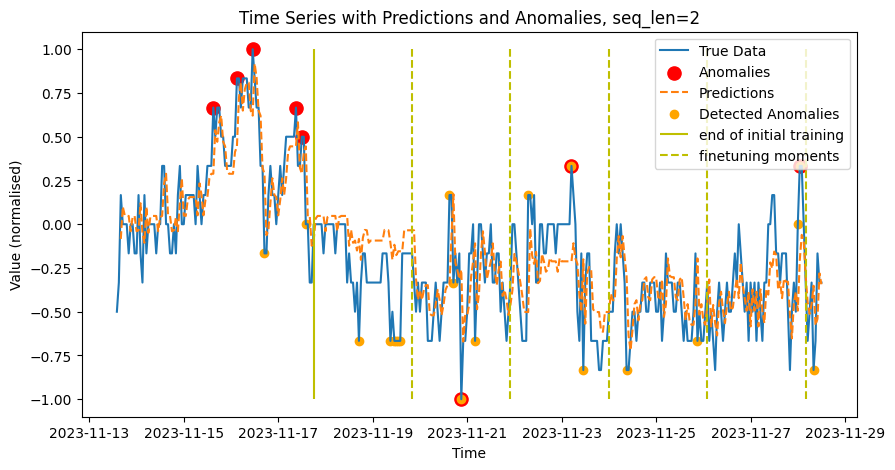

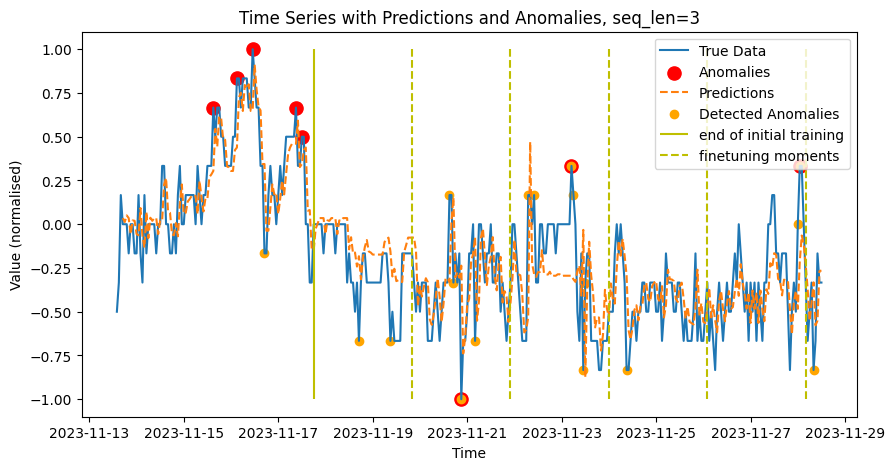

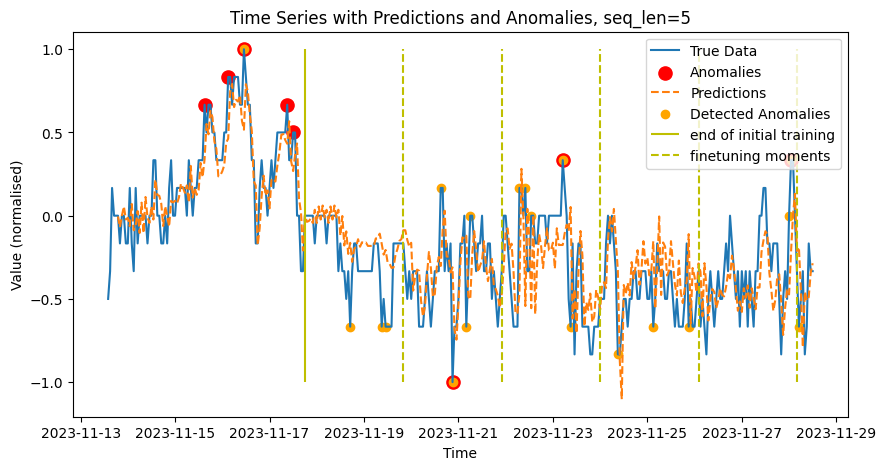

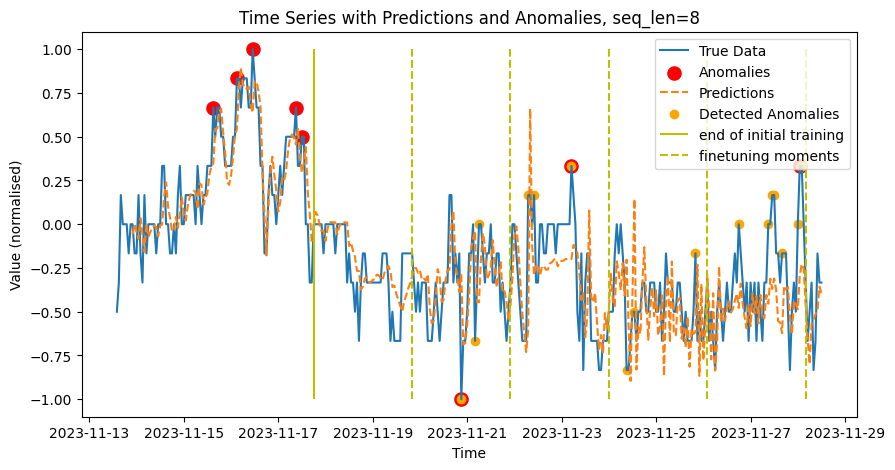

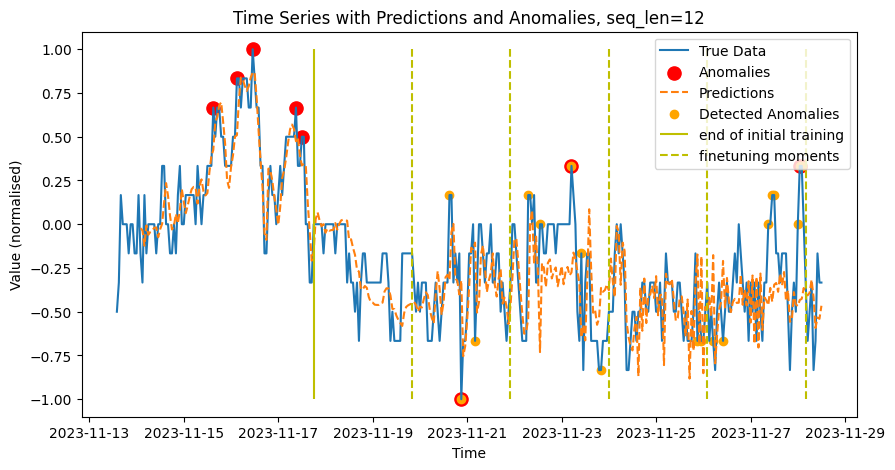

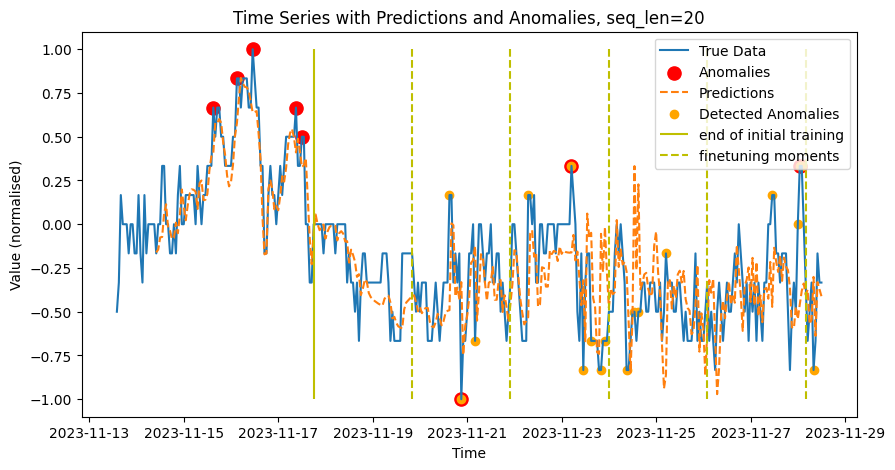

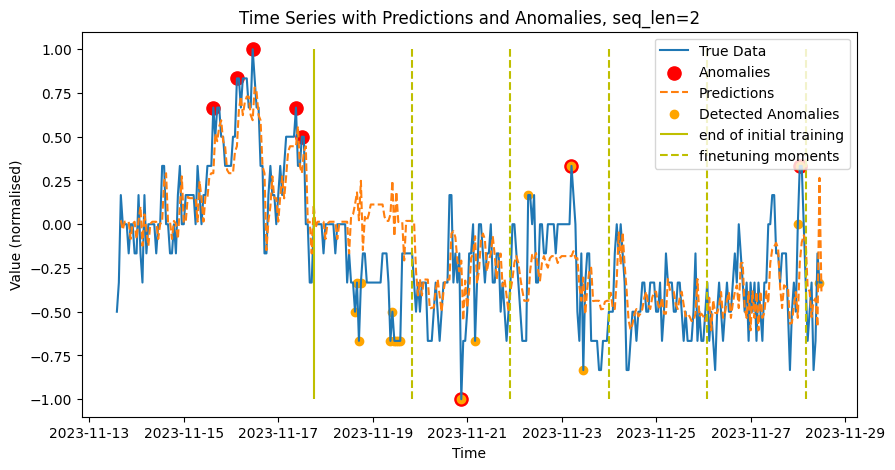

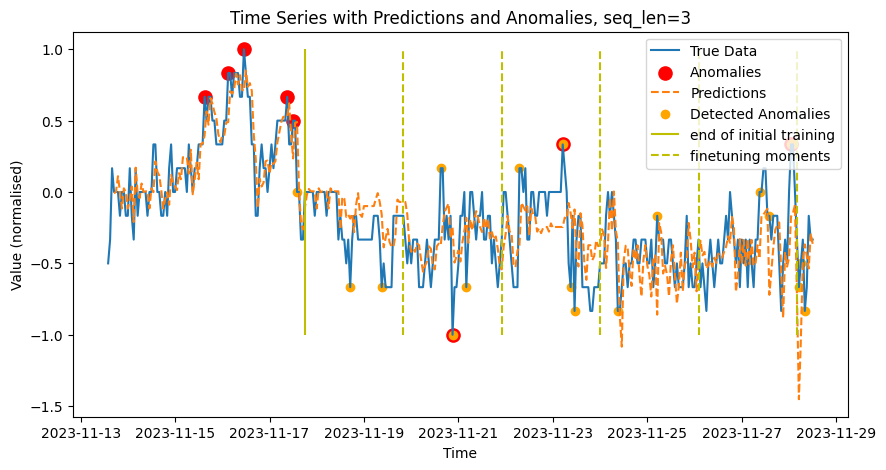

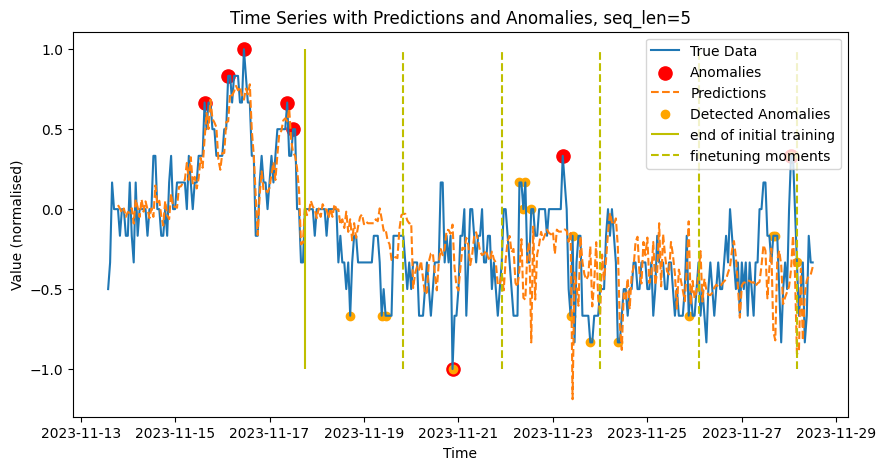

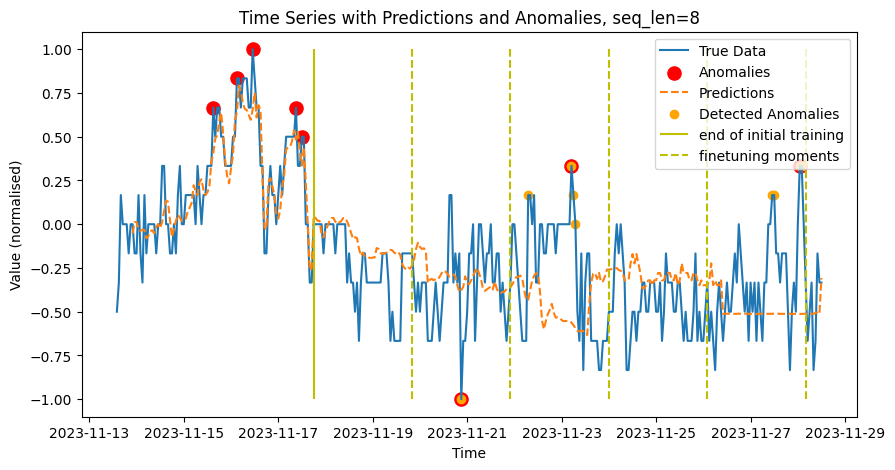

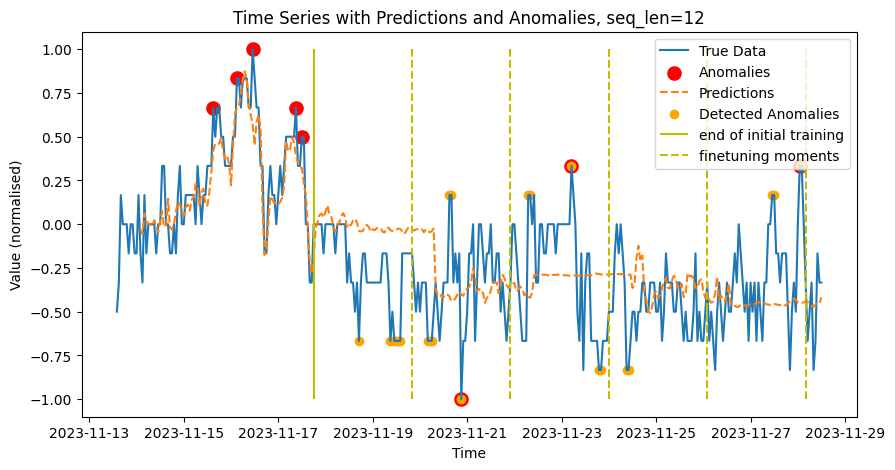

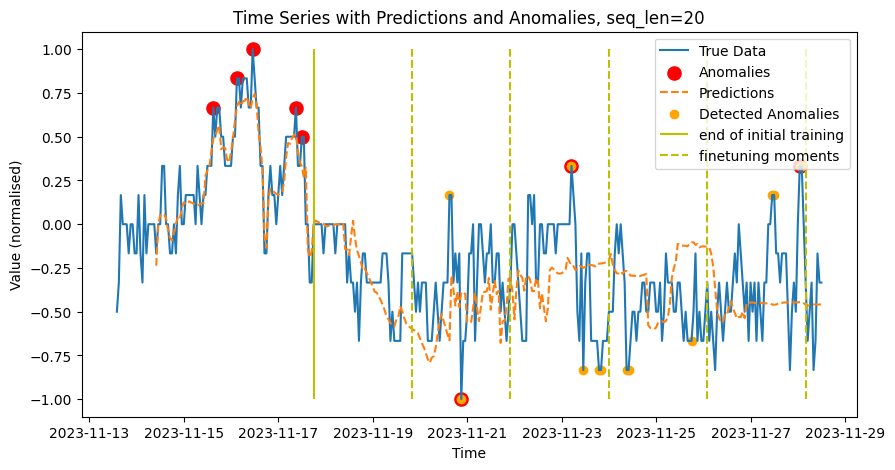

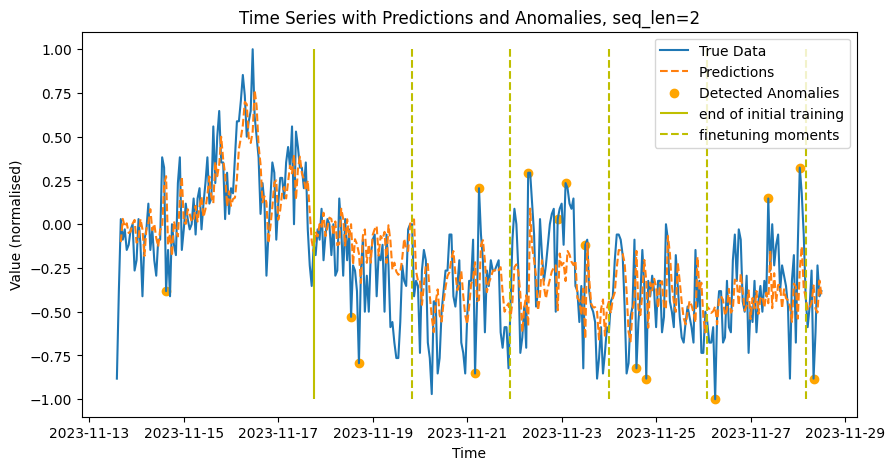

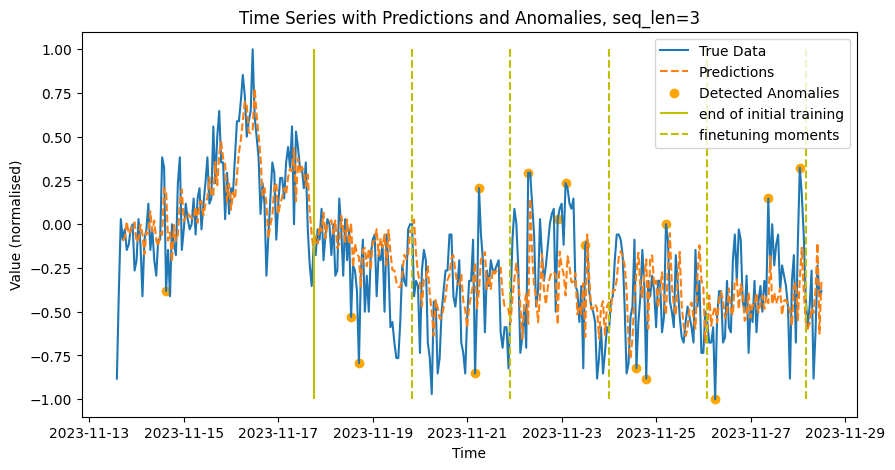

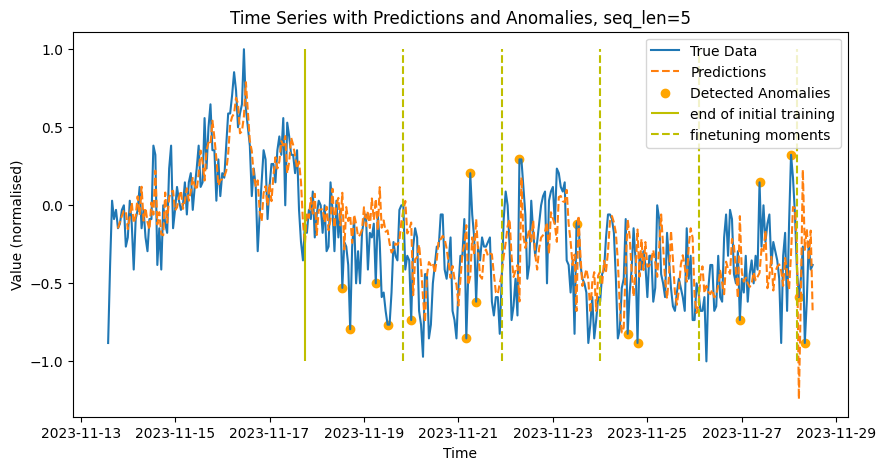

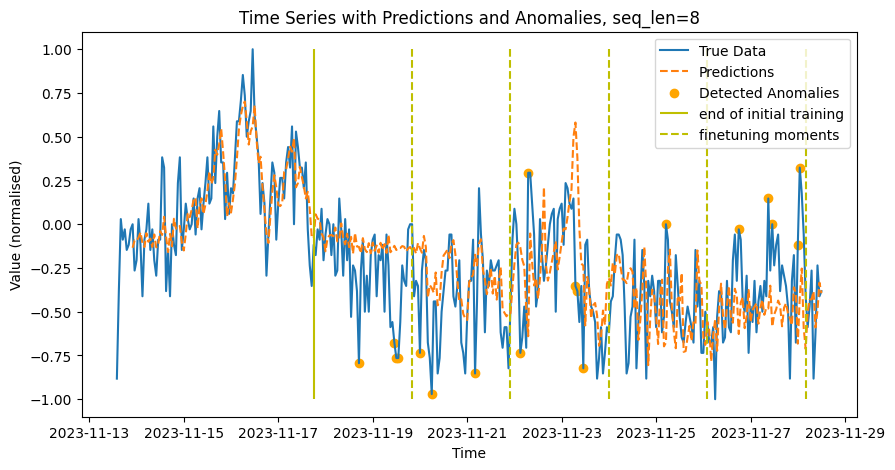

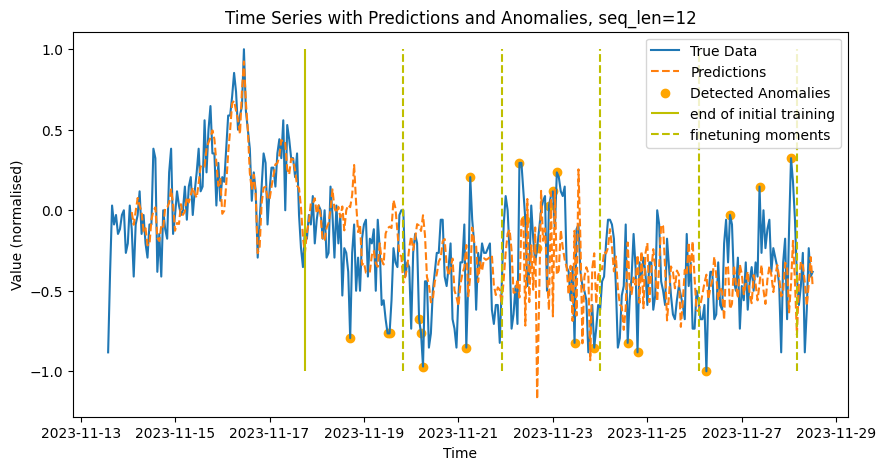

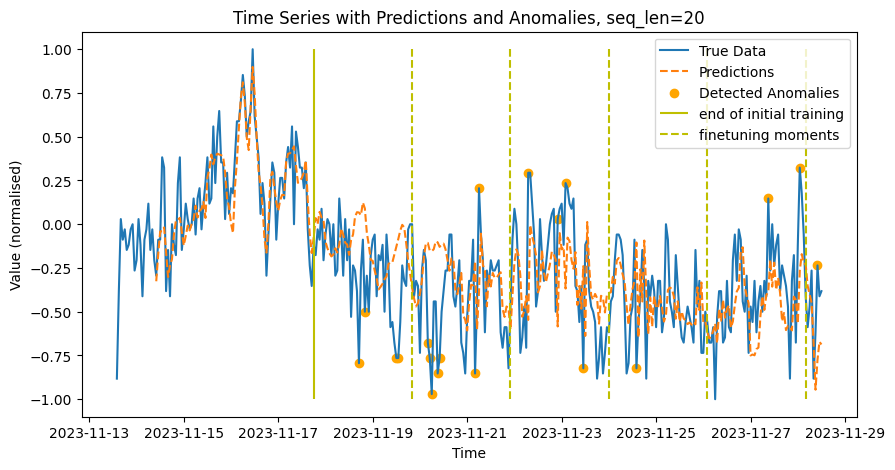

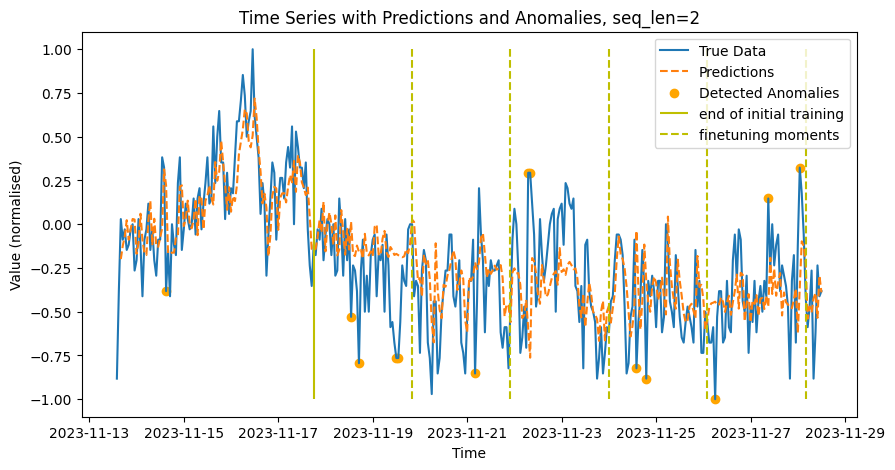

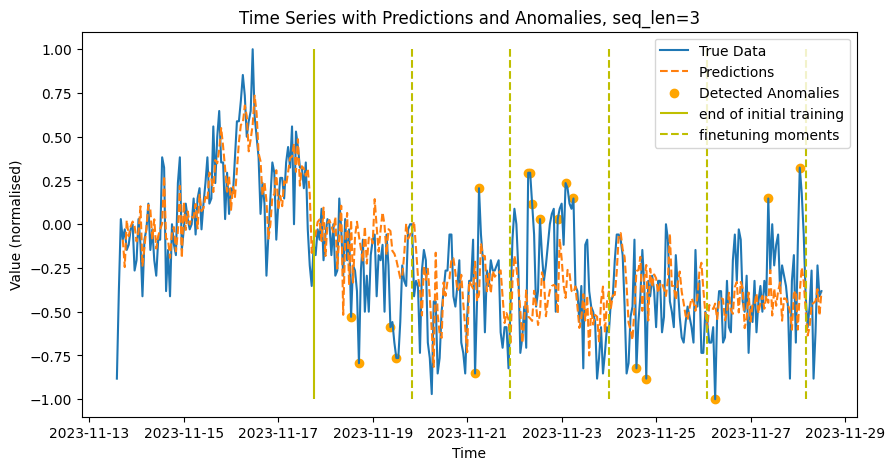

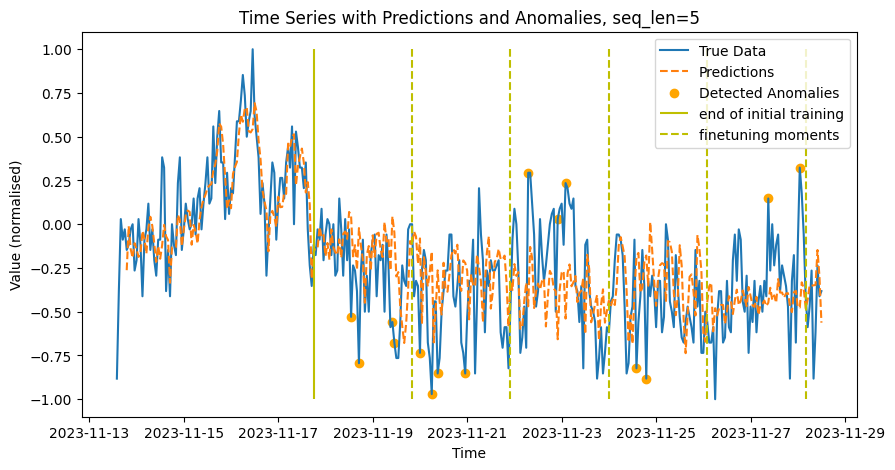

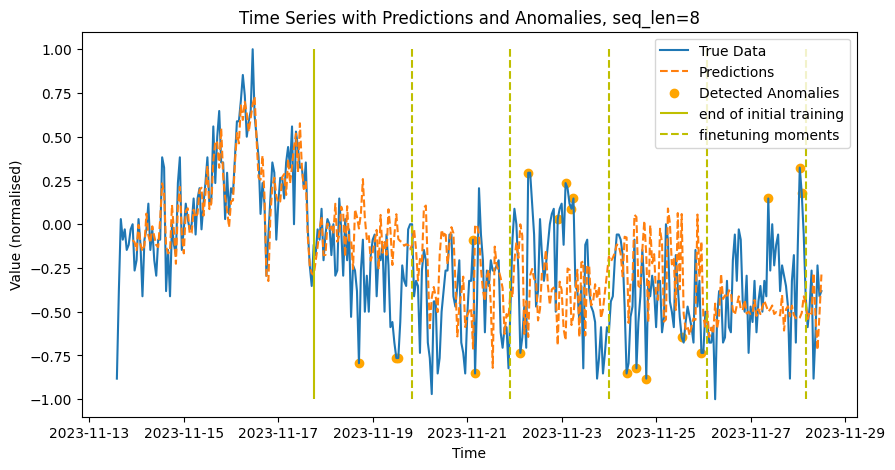

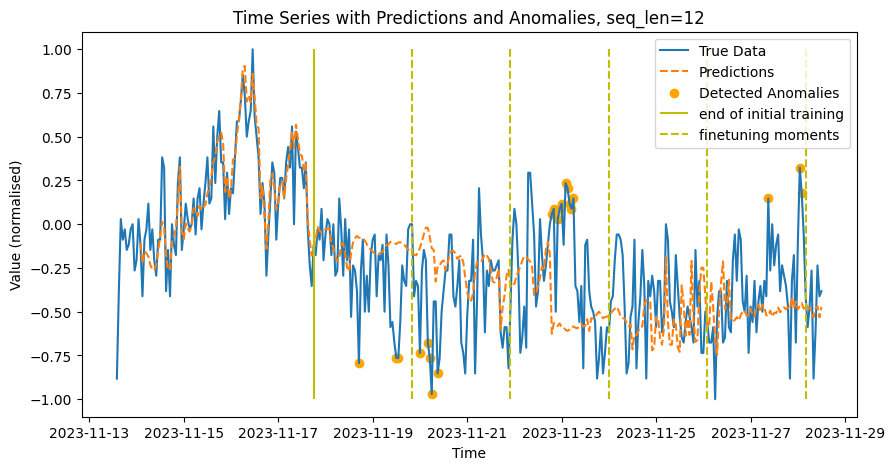

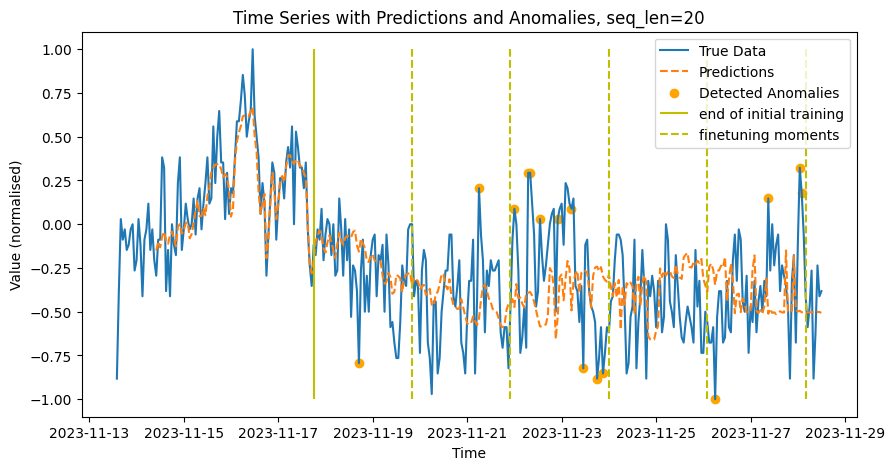

In [5]:
training_series_length = 100
finetuning_step = 50
threshold_scaler = 1.

for series_name, series in series_dict.items():
    for model_class in model_classes:
        x, y = preprocess_series(series)
        if series_name == 'series_original':
            anomalies = [49, 61, 69, 91, 94, 175, 231, 347]
        elif series_name == 'series_aug':
            anomalies = []
        for seq_len in seq_lengths:
            # print(f'seq_len={seq_len}')
            set_seed(42)
            model = model_class()
            X, Y = prepare_dataset(y, seq_len)

            
            pred = np.array([])
            for i in range(0, len(X)):
                if i == training_series_length:
                    # print(f'i={i}')
                    # print(f'len(pred)={len(pred)}')
                    # print(f'training_start=0')
                    # print(f'training_end={training_series_length -1 }')
                    
                    train_model(model,
                                X,
                                Y,
                                training_series_length,
                                epochs=training_series_length)
                    initial_pred = model_predict(model, X[0:training_series_length + finetuning_step])
                    pred = np.append(pred, initial_pred)
                    # print(f'len(pred)={len(pred)}')
                if all([i > training_series_length, 
                       (i - training_series_length) % finetuning_step == 0]):
                    # print(f'i={i}')
                    
                    training_start = i - finetuning_step
                    training_end = i
                    train_model(model, 
                                X[training_start:training_end],
                                Y[training_start:training_end],
                                epochs=finetuning_step)
                    if training_end + finetuning_step <= len(X):
                        new_pred = model_predict(model,
                                                 X[training_end:training_end + finetuning_step])
                    elif training_end + finetuning_step > len(X):
                        new_pred = model_predict(model,
                                                 X[training_end:])
                    pred = np.append(pred, new_pred)
                    # print(f'training_start={i- finetuning_step}')
                    # print(f'training_end={i - 1}')
                    # if len(range(training_end,len(X))) > 1:
                    #     print(f'len(new_pred)={len(new_pred)}')
                    # elif len(range(training_end,len(X))) == 1:
                    #     print(f'len(new_pred)=1')
                    # print(f'len(pred)={len(pred)}')
                    # print(f'len(X)={len(X)}')
                    
            
            detected_anomalies = detect_anomalies(pred, Y, seq_len, threshold_scaler=threshold_scaler)
            
            saving_path = create_saving_path(
                model,
                seq_len,
                series_name,
                folder='12_forec_fine-tuning',
                subfolder=f'threshold_scaler_{threshold_scaler:03.2f}'.replace('.', '-'))
            # saving_path = None
            plot_results(
                x,
                y,
                pred,
                anomalies,
                detected_anomalies,
                training_series_length,
                seq_len,
                saving_path,
                finetuning=True,
                finetuning_step=finetuning_step)